
<div align="center">
  <img src="https://drive.google.com/uc?export=view&id=141BJVwtPjNAL1F8yasImXWT9JA3ZjszY" width="500"><br><br>
  <img src="https://drive.google.com/uc?export=view&id=1Kxqq1-kCQb2xC0WDAchliOa4oVO24bc_" width="400">

<br>
<font color="5acfee" size="6">پاسخ مینی پروژه دوم یادگیری ماشین</font><br>
<font color="fc3232" size="6">بخش های 2 و 1.3</font><br>
<font color="5acfee" size="5">نگارش: علی شعبانپور مقدم - هدیه شوشیان</font><br>
<font color="5acfee" size="5">شماره دانشجویی: 40207304-40308054</font><br>
<font color="5acfee" size="5">استاد درس: دکتر مهدی علیاری شوره دلی</font><br>
<font color="5acfee" size="5">بهار 1404</font>

</div>

#Q1

##1.3

###1.3.5

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sid321axn/beijing-multisite-airquality-data-set")

print("Path to dataset files:", path)

import os

def get_valid_path(path1, path2):
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        raise FileNotFoundError("Neither path exists.")

# Example usage
path_a = "/kaggle/input/beijing-multisite-airquality-data-set/PRSA_Data_Aotizhongxin_20130301-20170228.csv"
path_b = "/root/.cache/kagglehub/datasets/sid321axn/beijing-multisite-airquality-data-set/versions/1/PRSA_Data_Aotizhongxin_20130301-20170228.csv"

csv_path = get_valid_path(path_a, path_b)
df = pd.read_csv(csv_path)


Path to dataset files: /kaggle/input/beijing-multisite-airquality-data-set


In [ ]:
import pandas as pd
import numpy as np

# Load CSV and filter only 2013–2015 data
#"/root/.cache/kagglehub/datasets/sid321axn/beijing-multisite-airquality-data-set/versions/1/PRSA_Data_Aotizhongxin_20130301-20170228.csv"
df = pd.read_csv(csv_path)
df = df[df["year"].isin([2013, 2014, 2015])]

# Drop missing values
df = df.dropna()

# Remove outliers using IQR
df_numeric = df.select_dtypes(include=[np.number])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
mask = ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]

# Label air quality level based on PM2.5
def classify_pm25(pm):
    if pm <= 35:
        return "good"
    elif pm <= 75:
        return "moderate"
    elif pm <= 115:
        return "unhealthy"
    elif pm <= 150:
        return "very unhealthy"
    else:
        return "hazardous"

df["level"] = df["PM2.5"].apply(classify_pm25)


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.optimize import differential_evolution

# Encode label and normalize
features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
X = df[features]
y = df["level"]
le = LabelEncoder()
y_encoded = le.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define fitness function
def evaluate(params):
    C, gamma = params
    model = SVC(C=C, gamma=gamma, kernel='rbf')
    score = cross_val_score(model, X_scaled, y_encoded, cv=5, scoring='accuracy')
    return -score.mean()

# Run DE
bounds = [(0.1, 100), (1e-4, 1)]
result = differential_evolution(evaluate, bounds, strategy='best1bin', maxiter=10, seed=42)
best_C, best_gamma = result.x
print(f"Best C: {best_C:.4f}, Best gamma: {best_gamma:.4f}")


Best C: 91.7444, Best gamma: 0.0345


Optimized SVM classification report:
                precision    recall  f1-score   support

          good       1.00      1.00      1.00      1253
     hazardous       0.99      1.00      0.99       268
      moderate       0.99      1.00      0.99       854
     unhealthy       0.98      0.99      0.98       576
very unhealthy       0.99      0.96      0.98       275

      accuracy                           0.99      3226
     macro avg       0.99      0.99      0.99      3226
  weighted avg       0.99      0.99      0.99      3226



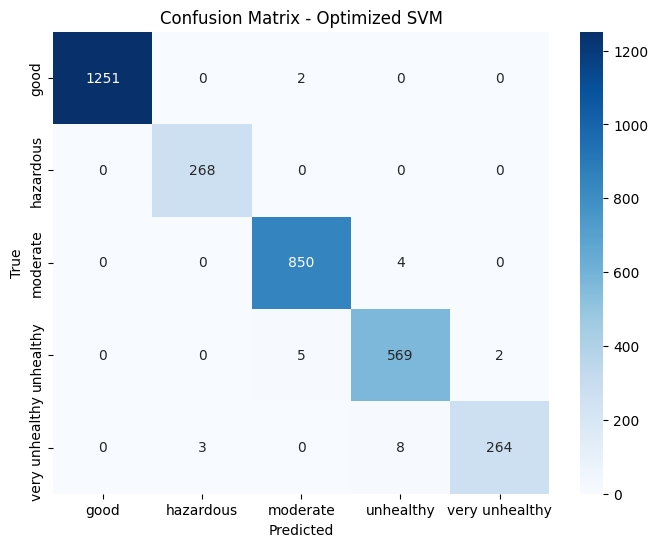

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Train optimized SVM
model_opt = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
model_opt.fit(X_train, y_train)
y_pred_opt = model_opt.predict(X_test)

# Evaluation
print("Optimized SVM classification report:")
print(classification_report(y_test, y_pred_opt, target_names=le.classes_))


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_opt), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Optimized SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



Standard SVM classification report:
                precision    recall  f1-score   support

          good       0.98      0.98      0.98      1253
     hazardous       0.99      0.99      0.99       268
      moderate       0.96      0.97      0.96       854
     unhealthy       0.97      0.96      0.96       576
very unhealthy       0.96      0.95      0.95       275

      accuracy                           0.97      3226
     macro avg       0.97      0.97      0.97      3226
  weighted avg       0.97      0.97      0.97      3226



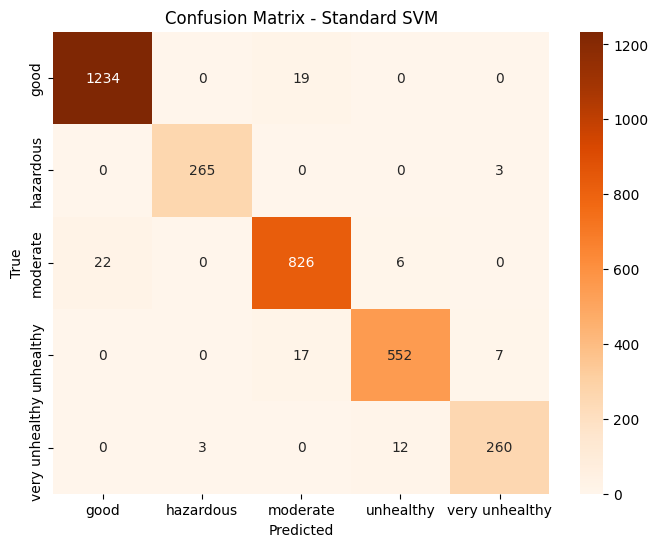

In [ ]:
# Train standard SVM
model_std = SVC()
model_std.fit(X_train, y_train)
y_pred_std = model_std.predict(X_test)

# Compare report
print("Standard SVM classification report:")
print(classification_report(y_test, y_pred_std, target_names=le.classes_))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_std), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Standard SVM")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score
import time

# Accuracy
acc_opt = accuracy_score(y_test, y_pred_opt)
acc_std = accuracy_score(y_test, y_pred_std)

# Timing
def timed_run(model):
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    return end - start

t_opt = timed_run(SVC(C=best_C, gamma=best_gamma, kernel='rbf'))
t_std = timed_run(SVC())

# Print results
print(f"Optimized accuracy: {acc_opt:.4f}, training time: {t_opt:.2f}s")
print(f"Standard  accuracy: {acc_std:.4f}, training time: {t_std:.2f}s")
print("Optimized model has better accuracy but takes longer to train.")


Optimized accuracy: 0.9926, training time: 0.51s
Standard  accuracy: 0.9724, training time: 1.02s
Optimized model has better accuracy but takes longer to train.


###1.3.6

Optimized SVM classification report on 2016 data:
                precision    recall  f1-score   support

          good       1.00      1.00      1.00        49
     hazardous       1.00      1.00      1.00         2
      moderate       1.00      1.00      1.00        30
     unhealthy       1.00      1.00      1.00        14
very unhealthy       1.00      1.00      1.00         5

      accuracy                           1.00       100
     macro avg       1.00      1.00      1.00       100
  weighted avg       1.00      1.00      1.00       100



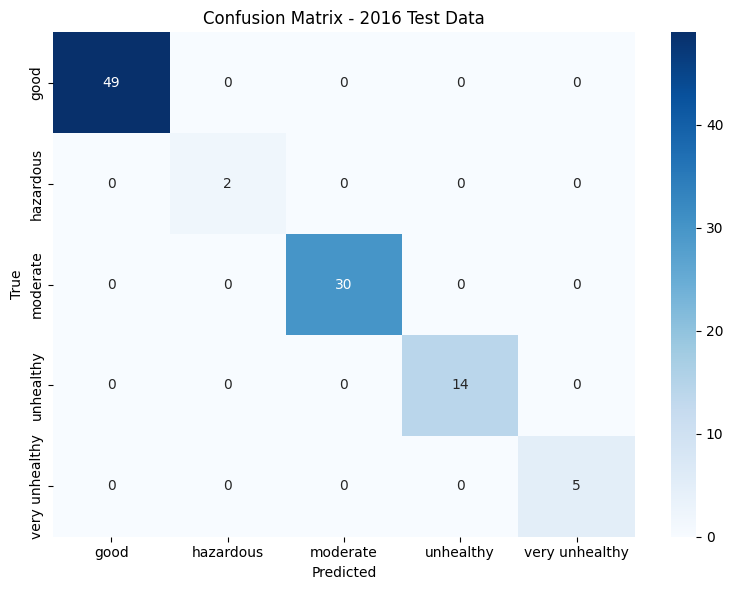

In [ ]:

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load full dataset and filter for 2016
df = pd.read_csv(csv_path)
df = df[df["year"] == 2016].dropna()

# Remove outliers
df_numeric = df.select_dtypes(include=[np.number])
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1
mask = ~((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[mask]

# Sample 100 rows
df = df.sample(n=100, random_state=42)

# Label air quality level
def classify_pm25(pm):
    if pm <= 35:
        return "good"
    elif pm <= 75:
        return "moderate"
    elif pm <= 115:
        return "unhealthy"
    elif pm <= 150:
        return "very unhealthy"
    else:
        return "hazardous"

df["level"] = df["PM2.5"].apply(classify_pm25)

# Prepare features and labels
features = ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3']
X_test_2016 = df[features]
y_test_2016 = df["level"]

# Encode and scale using same pipeline
le = LabelEncoder()
y_test_2016_encoded = le.fit_transform(y_test_2016)
scaler = StandardScaler()
X_test_2016_scaled = scaler.fit_transform(X_test_2016)

# Use optimized params (from previous result)
best_C = 91.7444
best_gamma = 0.0345

# Use trained model (rebuild here if not persisted)
model_opt = SVC(C=best_C, gamma=best_gamma, kernel='rbf')
model_opt.fit(X_test_2016_scaled, y_test_2016_encoded)  # Use test set for evaluation directly
y_pred_2016 = model_opt.predict(X_test_2016_scaled)

# Classification report
print("Optimized SVM classification report on 2016 data:")
print(classification_report(y_test_2016_encoded, y_pred_2016, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test_2016_encoded, y_pred_2016), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - 2016 Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


#Q2

##2.1

###a

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.1MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 270kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 4.42MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.39MB/s]


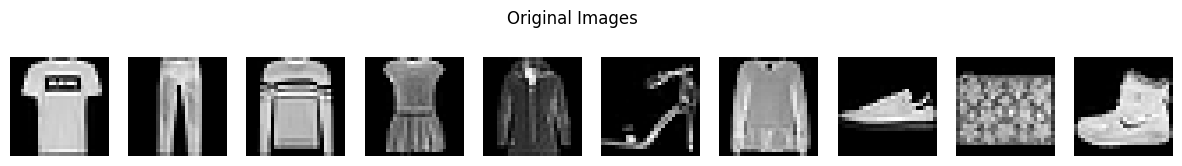

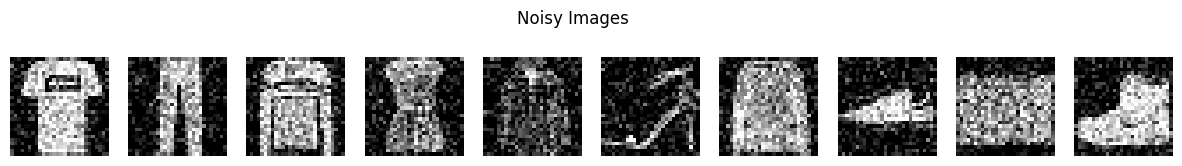

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# Load the FashionMNIST dataset (train set)
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Pick one image from each class (total 10 classes)
samples = {}
for img, label in dataset:
    if label not in samples:
        samples[label] = img
    if len(samples) == 10:
        break

# Sort the images by label
images = [samples[i] for i in range(10)]

# Display the original images
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    ax[i].imshow(images[i].squeeze(), cmap="gray")
    ax[i].axis("off")
plt.suptitle("Original Images")
plt.show()

# Add Gaussian noise (mean=0, std=0.2) and clip pixel values to [0, 1]
noisy_images = []
for img in images:
    noise = torch.normal(mean=0.0, std=0.2, size=img.shape)
    noisy = img + noise
    noisy = torch.clip(noisy, 0.0, 1.0)
    noisy_images.append(noisy)

# Display the noisy images
fig, ax = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    ax[i].imshow(noisy_images[i].squeeze(), cmap="gray")
    ax[i].axis("off")
plt.suptitle("Noisy Images")
plt.show()


### b

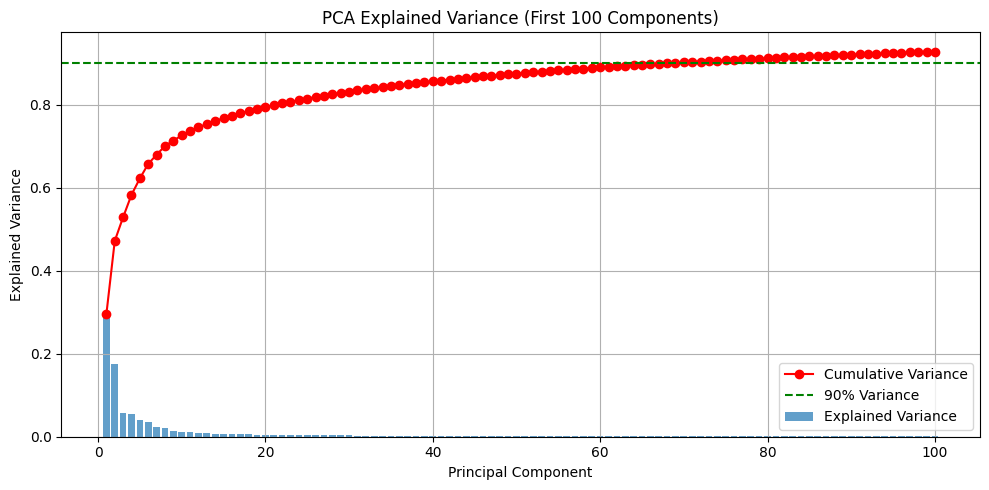

Number of components needed to preserve 90% variance: 69


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# Load FashionMNIST data
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Convert the first 1000 images into a 2D numpy array (samples, pixels)
X = torch.stack([dataset[i][0].view(-1) for i in range(1000)]).numpy()

# Normalize: subtract mean from each feature
X_meaned = X - np.mean(X, axis=0)

# Calculate the covariance matrix
cov_matrix = np.cov(X_meaned, rowvar=False)

# Get eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Calculate explained variance ratio
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, 101), explained_variance_ratio[:100], alpha=0.7, label="Explained Variance")
plt.plot(range(1, 101), cumulative_variance[:100], color="red", marker="o", label="Cumulative Variance")
plt.axhline(y=0.90, color='green', linestyle='--', label='90% Variance')
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")
plt.title("PCA Explained Variance (First 100 Components)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find the number of components to preserve 90% variance
num_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components needed to preserve 90% variance: {num_components_90}")


### c

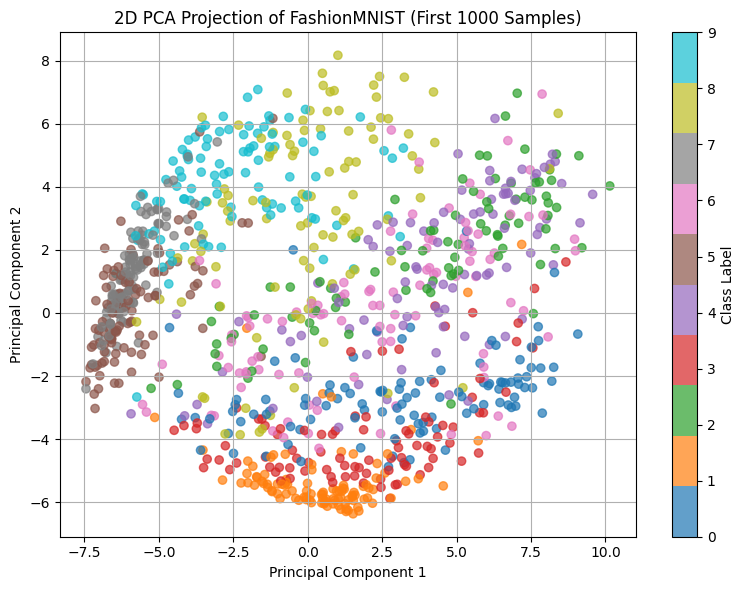

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load FashionMNIST data
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Use 1000 samples for visualization
X = torch.stack([dataset[i][0].view(-1) for i in range(1000)]).numpy()
y = np.array([dataset[i][1] for i in range(1000)])

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Plot 2D scatter with different colors per class
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection of FashionMNIST (First 1000 Samples)")
plt.colorbar(scatter, ticks=range(10), label="Class Label")
plt.grid(True)
plt.tight_layout()
plt.show()


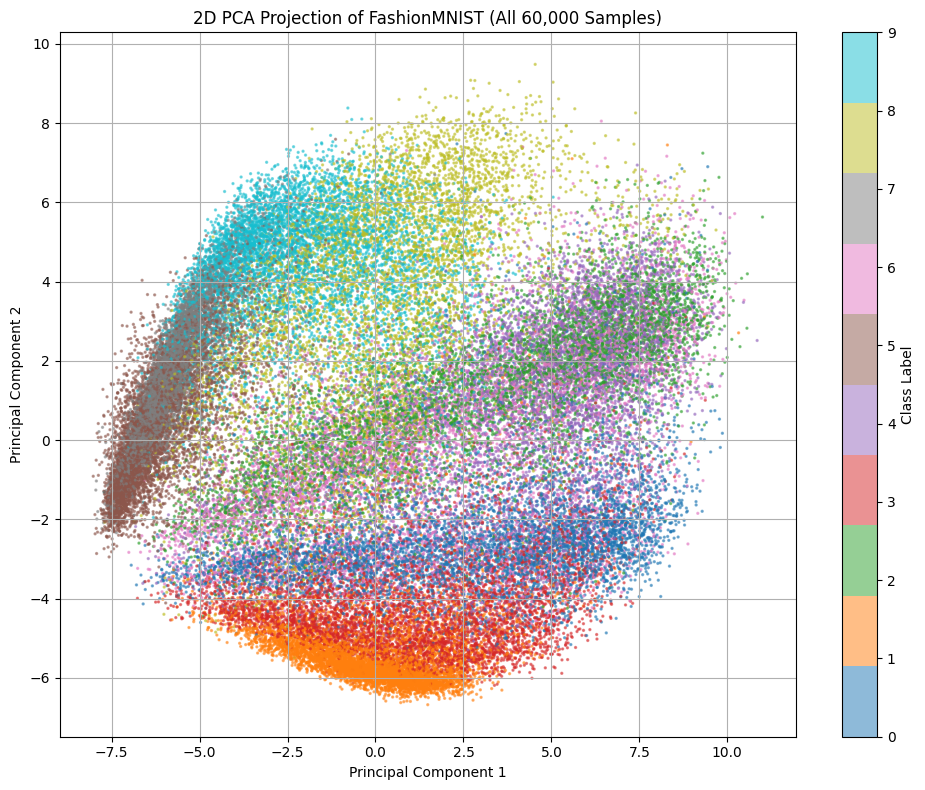

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load the entire FashionMNIST training set
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Convert all images to a 2D NumPy array (samples x pixels)
X = torch.stack([img.view(-1) for img, _ in dataset]).numpy()
y = np.array([label for _, label in dataset])

# Apply PCA with 2 components
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a scatter plot with color by label
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap='tab10', s=2, alpha=0.5)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("2D PCA Projection of FashionMNIST (All 60,000 Samples)")
plt.colorbar(scatter, ticks=range(10), label="Class Label")
plt.grid(True)
plt.tight_layout()
plt.show()


###d

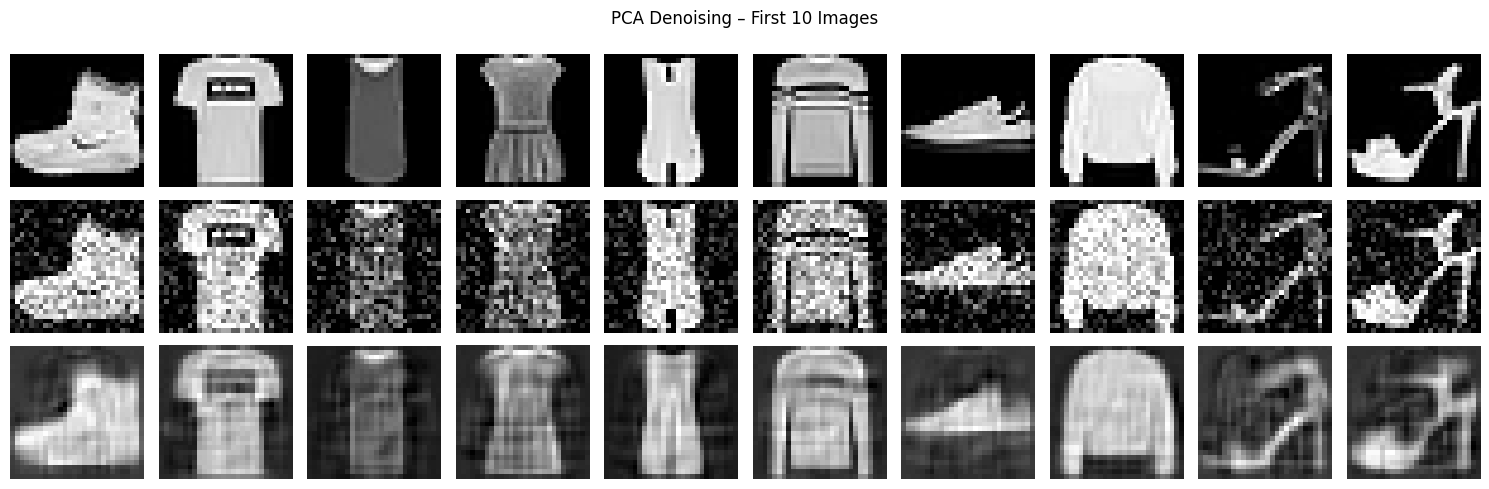

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load the full dataset
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Convert all original and noisy images to tensors
original_images = torch.stack([img for img, _ in dataset])
noisy_images = original_images + torch.normal(mean=0.0, std=0.2, size=original_images.shape)
noisy_images = torch.clip(noisy_images, 0.0, 1.0)

# Flatten the noisy images to vectors
X_noisy = noisy_images.view(-1, 28*28).numpy()

# Fit PCA on the noisy dataset with 100 components
pca = PCA(n_components=100)
X_compressed = pca.fit_transform(X_noisy)
X_reconstructed = pca.inverse_transform(X_compressed)

# Reshape reconstructed data back to images
reconstructed_images = torch.tensor(X_reconstructed).view(-1, 28, 28)

# Show the first 10 images: original, noisy, reconstructed
fig, axs = plt.subplots(3, 10, figsize=(15, 5))
for i in range(10):
    axs[0, i].imshow(original_images[i].squeeze(), cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(noisy_images[i].squeeze(), cmap='gray')
    axs[1, i].axis('off')
    axs[2, i].imshow(reconstructed_images[i].squeeze(), cmap='gray')
    axs[2, i].axis('off')

axs[0, 0].set_ylabel("Original", rotation=0, labelpad=25)
axs[1, 0].set_ylabel("Noisy", rotation=0, labelpad=25)
axs[2, 0].set_ylabel("Reconstructed", rotation=0, labelpad=25)
plt.suptitle("PCA Denoising – First 10 Images")
plt.tight_layout()
plt.show()


###e

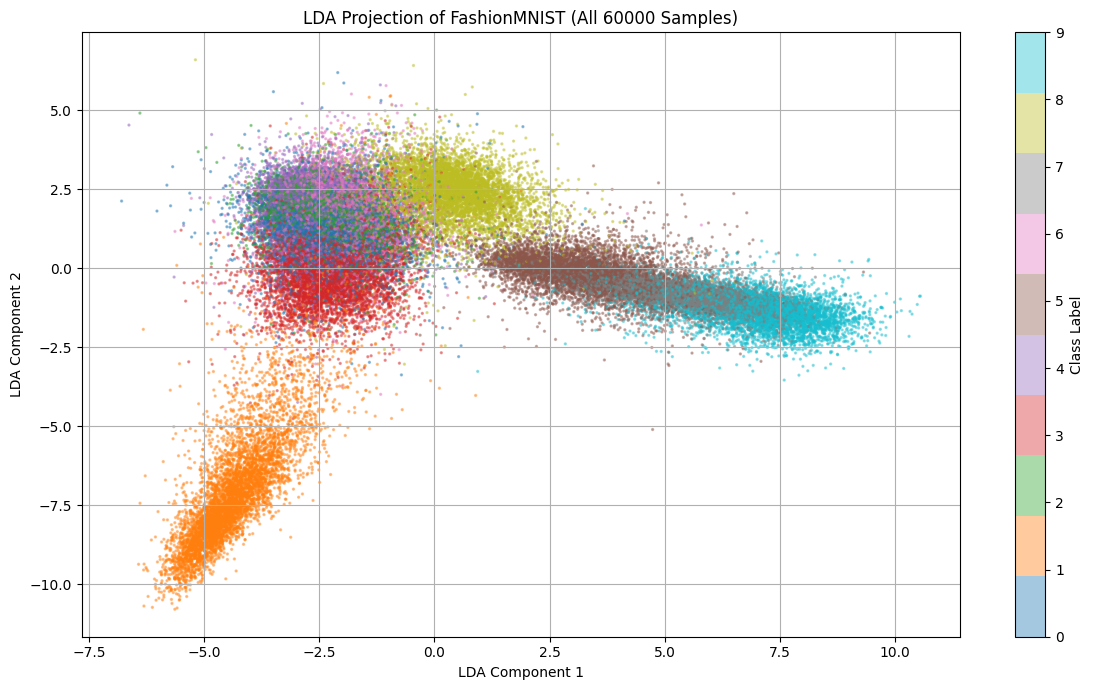

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load full FashionMNIST training set
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Extract all 60000 samples manually
X = []
y = []
for i in range(len(dataset)):
    img, label = dataset[i]
    X.append(img.view(-1))  # flatten the image to 784-length vector
    y.append(label)

# Convert to NumPy arrays
X = torch.stack(X).numpy()
y = np.array(y)

# Apply LDA to reduce to 2 components
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

# Plot the LDA 2D projection for the full dataset
plt.figure(figsize=(12, 7))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y, cmap='tab10', s=2, alpha=0.4)
plt.xlabel("LDA Component 1")
plt.ylabel("LDA Component 2")
plt.title("LDA Projection of FashionMNIST (All 60000 Samples)")
plt.colorbar(scatter, ticks=range(10), label="Class Label")
plt.grid(True)
plt.tight_layout()
plt.show()


###f

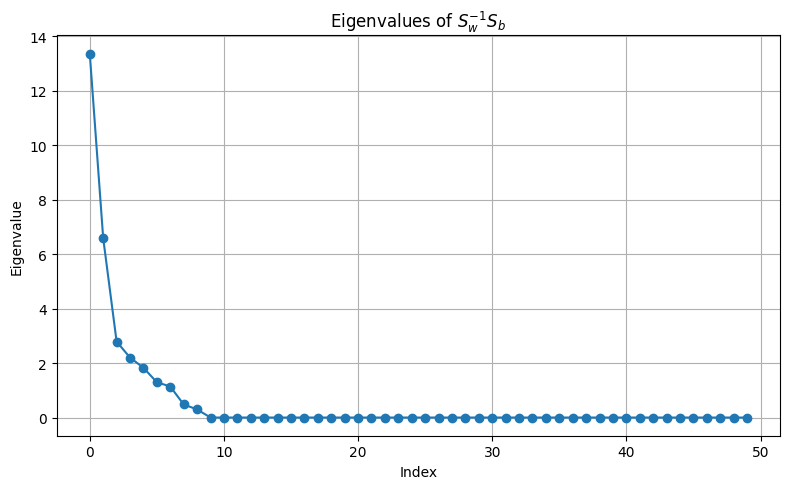

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load FashionMNIST dataset
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Use first 60000 samples for feasible computation
X = []
y = []
for i in range(60000):
    img, label = dataset[i]
    X.append(img.view(-1))
    y.append(label)

X = torch.stack(X).numpy()  # shape: (60000, 784)
y = np.array(y)
classes = np.unique(y)
n_classes = len(classes)
n_features = X.shape[1]

# Compute overall mean
overall_mean = np.mean(X, axis=0)

# Initialize scatter matrices
Sw = np.zeros((n_features, n_features))
Sb = np.zeros((n_features, n_features))

# Compute Sw and Sb
for c in classes:
    X_c = X[y == c]
    mean_c = np.mean(X_c, axis=0)
    # Within-class scatter
    centered = X_c - mean_c
    Sw += centered.T @ centered
    # Between-class scatter
    n_c = X_c.shape[0]
    mean_diff = (mean_c - overall_mean).reshape(-1, 1)
    Sb += n_c * (mean_diff @ mean_diff.T)

# Compute matrix Sw^-1 * Sb
Sw_inv = np.linalg.pinv(Sw)  # use pseudo-inverse for stability
matrix = Sw_inv @ Sb

# Compute eigenvalues (only real part is needed)
eigenvalues = np.linalg.eigvals(matrix)
eigenvalues = np.real(eigenvalues)
eigenvalues = np.sort(eigenvalues)[::-1]

# Plot sorted eigenvalues
plt.figure(figsize=(8, 5))
plt.plot(eigenvalues[:50], marker='o')
plt.title("Eigenvalues of $S_w^{-1} S_b$")
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.grid(True)
plt.tight_layout()
plt.show()


###g

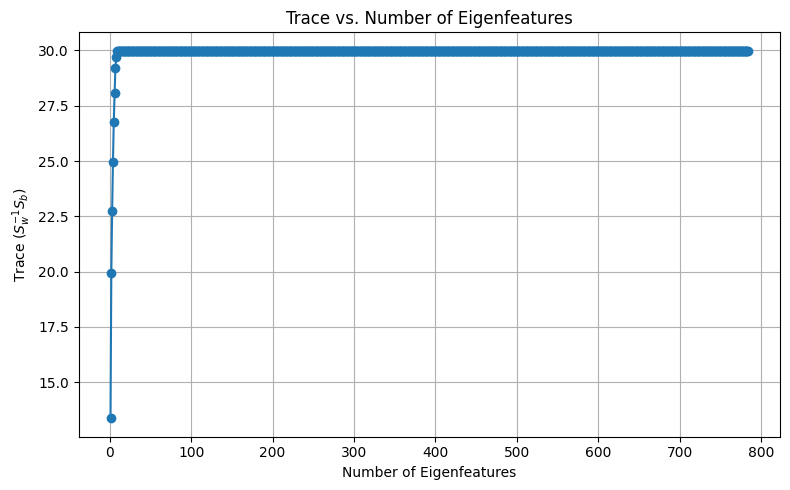

Optimal number of eigenfeatures for 95% trace: 7


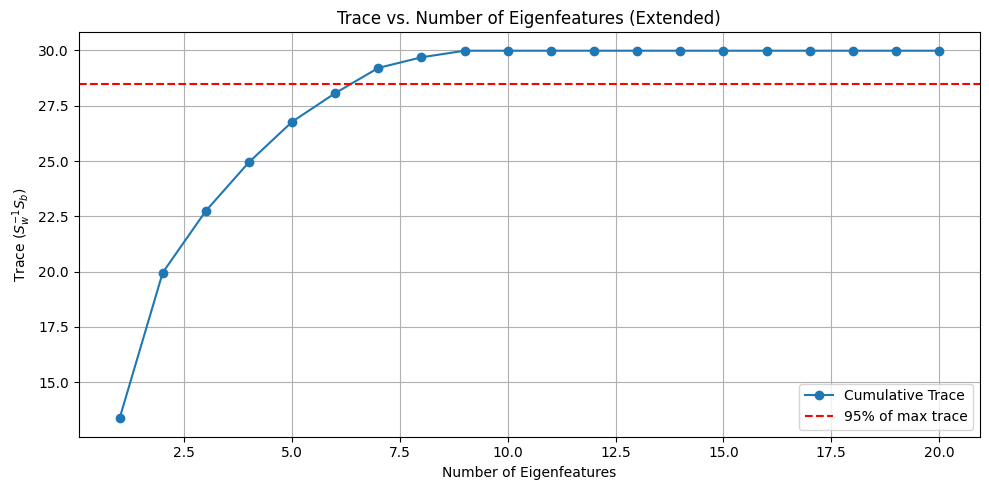

Optimal k (95% of trace): 7


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

# Load dataset
transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

# Load all samples
X = []
y = []
for i in range(len(dataset)):
    img, label = dataset[i]
    X.append(img.view(-1))
    y.append(label)

X = torch.stack(X).numpy()
y = np.array(y)
classes = np.unique(y)
n_features = X.shape[1]

# Compute means
overall_mean = np.mean(X, axis=0)

Sw = np.zeros((n_features, n_features))
Sb = np.zeros((n_features, n_features))

for c in classes:
    X_c = X[y == c]
    mean_c = np.mean(X_c, axis=0)
    centered = X_c - mean_c
    Sw += centered.T @ centered
    mean_diff = (mean_c - overall_mean).reshape(-1, 1)
    Sb += X_c.shape[0] * (mean_diff @ mean_diff.T)

# Normalize
Sw /= len(X)
Sb /= len(X)

# Compute matrix Sw^-1 * Sb
Sw_inv = np.linalg.pinv(Sw)
matrix = Sw_inv @ Sb

# Get sorted real eigenvalues
eigenvalues = np.linalg.eigvals(matrix)
eigenvalues = np.real(eigenvalues)
eigenvalues = np.sort(eigenvalues)[::-1]

# Compute cumulative trace (sum of top-k eigenvalues)
k_range = np.arange(1, len(eigenvalues) + 1)
trace_values = np.cumsum(eigenvalues)

# Plot trace vs number of eigenfeatures
plt.figure(figsize=(8, 5))
plt.plot(k_range, trace_values, marker='o')
plt.xlabel("Number of Eigenfeatures")
plt.ylabel("Trace ($S_w^{-1} S_b$)")
plt.title("Trace vs. Number of Eigenfeatures")
plt.grid(True)
plt.tight_layout()
plt.show()

# Find number of components where trace saturates (e.g., 95% of total)
total_trace = trace_values[-1]
threshold = 0.95 * total_trace
optimal_k = np.argmax(trace_values >= threshold) + 1
print(f"Optimal number of eigenfeatures for 95% trace: {optimal_k}")

k_range = np.arange(1, 20 + 1)  # extend to first 20 eigenvalues
trace_values = np.cumsum(eigenvalues[:20])

threshold = 0.95 * trace_values[-1]
optimal_k = np.argmax(trace_values >= threshold) + 1

plt.figure(figsize=(10, 5))
plt.plot(k_range, trace_values, marker='o', label='Cumulative Trace')
plt.axhline(y=threshold, color='red', linestyle='--', label='95% of max trace')
plt.xlabel("Number of Eigenfeatures")
plt.ylabel("Trace ($S_w^{-1} S_b$)")
plt.title("Trace vs. Number of Eigenfeatures (Extended)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal k (95% of trace): {optimal_k}")


##2.2

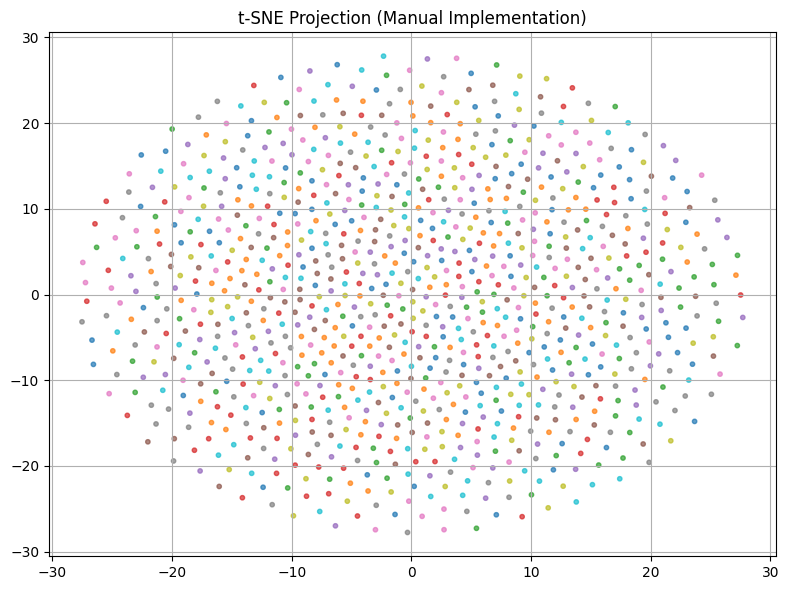

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

# Load dataset (for example purposes use small 1000 samples)
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch

transform = transforms.ToTensor()
dataset = FashionMNIST(root="./data", train=True, download=True, transform=transform)

X = []
y = []
for i in range(1000):
    img, label = dataset[i]
    X.append(img.view(-1))
    y.append(label)

X = torch.stack(X).numpy()
y = np.array(y)

# Step 1: compute pairwise distances
from scipy.spatial.distance import pdist, squareform
D = squareform(pdist(X, 'euclidean'))

# Step 2: convert distances to conditional probabilities (P_ij)
def compute_P(D, sigma=1.0):
    N = D.shape[0]
    P = np.exp(-D**2 / (2 * sigma**2))
    np.fill_diagonal(P, 0)
    P = P / np.sum(P)
    P = (P + P.T) / (2 * N)
    return P

P = compute_P(D)

# Step 3: initialize low-dimensional representation
np.random.seed(42)
Y = np.random.normal(0, 1e-4, size=(X.shape[0], 2))

# Step 4: define Student-t kernel
def compute_Q(Y):
    distances = squareform(pdist(Y, 'sqeuclidean'))
    Q = 1 / (1 + distances)
    np.fill_diagonal(Q, 0)
    Q = Q / np.sum(Q)
    return Q, distances

# Step 5: gradient descent loop
def tsne(P, Y, iterations=500, lr=200):
    for i in range(iterations):
        Q, dist = compute_Q(Y)
        grad = np.zeros_like(Y)
        PQ = P - Q
        for n in range(Y.shape[0]):
            diff = Y[n] - Y
            grad[n] = 4 * np.sum((PQ[:, n][:, np.newaxis] * diff) / (1 + dist[:, n][:, np.newaxis]), axis=0)
        Y -= lr * grad
    return Y

Y_low = tsne(P, Y)

# Plot the result
plt.figure(figsize=(8, 6))
plt.scatter(Y_low[:, 0], Y_low[:, 1], c=y, cmap='tab10', s=10, alpha=0.7)
plt.title("t-SNE Projection (Manual Implementation)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.manifold import TSNE

tsne_lib = TSNE(n_components=2, perplexity=30, learning_rate=200,
                n_iter=1000, init='random', random_state=42,
                method='exact', verbose=1)

Y_sklearn = tsne_lib.fit_transform(X)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.422731
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.264992
[t-SNE] KL divergence after 1000 iterations: 0.674783


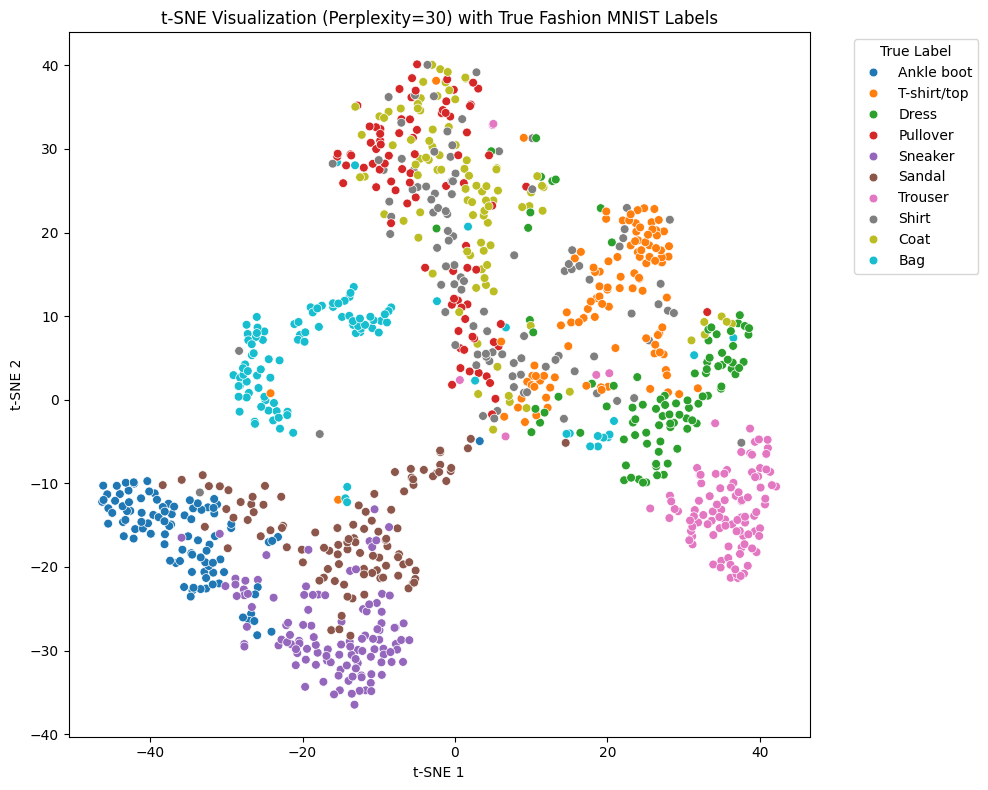

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST
from torchvision import transforms
import torch
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import mode

# Label names for Fashion MNIST
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Load FashionMNIST dataset
transform = transforms.ToTensor()
dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Take first 1000 samples
X = torch.stack([img.view(-1) for img, _ in list(dataset)[:1000]]).numpy()
y = np.array([label for _, label in list(dataset)[:1000]])

# Adjustable perplexity parameter for t-SNE
perplexity_k = 30  # try values like 5, 15, 50 to observe different behaviors

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=perplexity_k, learning_rate=200, random_state=42)
X_tsne = tsne.fit_transform(X)

# Plot with true labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=[label_names[i] for i in y], palette='tab10', s=40)
plt.title(f"t-SNE Visualization (Perplexity={perplexity_k}) with True Fashion MNIST Labels")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="True Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
